In [59]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16, vgg16_bn, resnet18, resnet34, resnet50, resnet101

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.metrics import f1_score

import seaborn as sn

from os import listdir, path
from PIL import Image
from collections import defaultdict
import csv
import re

from IPython.display import display, clear_output, Image as IPython_Image

In [2]:
torch.cuda.is_available()

True

# Data loading

In [3]:
IMAGE_PATH = '../data/images'
LABEL_PATH = '../data/annotations'

# GIVEN DATASET
MEAN = (0.43672, 0.40107, 0.36762)
STD = (0.30139, 0.28781, 0.29236)

# IMAGENET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)

# RESNET
#MEAN = (0.485, 0.456, 0.406)
#STD = (0.229, 0.224, 0.225)
       
# Define default pos_weights for nn.BCEWithLogitsLoss(pos_weights). If the get_dataloader() is run, is will 
# overwrite this variable based on the statistics of the test set.
label_pos_weights_for_loss = np.array([209.52631579, 55.87203791, 58.40594059, 16.77777778, 44.80152672, 5.25, 25.14379085, 5.75675676, 33.09090909, 2.15540363, 5.51465798, 163.38356164, 119., 37.46153846], dtype=np.float32)

In [4]:
def number_of_classes():
    return len(listdir(LABEL_PATH))

In [5]:
def get_class_map():
    ret = {}

    i = 0
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        ret[img_class] = i
        i += 1

    return ret

In [6]:
def write_labels_to_csv(name_of_set, label_array):
    filepath = f'../data/labels_{name_of_set}.csv'
    
    label_arr = np.array(label_array).astype(int)

    # Save 2D numpy array to csv file
    np.savetxt(filepath, label_arr, delimiter=',', fmt='%d')

In [7]:
def calculate_label_statistics(label_array, total_n_images):
    label_arr = np.array(label_array).astype(int)
    pos_label_counts_all = np.sum(label_arr, axis=0)
    neg_label_counts_all = total_n_images - pos_label_counts_all
    relative_label_occurrances =  pos_label_counts_all/total_n_images
    pos_weights = neg_label_counts_all / pos_label_counts_all
    
    return pos_weights, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances

In [8]:
def print_label_statistics(name_of_set, pos_weights, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances):    
    print(f'\nData set: {name_of_set}')
    print(' Positive label counts\n  ', pos_label_counts_all)
    print(' Negative label counts\n  ', neg_label_counts_all)
    print(' Relative label occurrances\n  ', relative_label_occurrances)
    print(' Pos_weights\n  ', pos_weights)

In [64]:
n_image_files = len([name for name in listdir(IMAGE_PATH) if path.isfile(path.join(IMAGE_PATH, name))])

indices = np.arange(n_image_files)
print(indices)

[    0     1     2 ... 19997 19998 19999]


In [109]:
def get_dataloader(bs=256, train_fr=.6, max_images_per_class=1e9, use_no_label_imgs = True, transformations=None):
    
    tensor_transformation = transforms.Compose([transforms.ToTensor()])
    pil_transformation = transforms.Compose([transforms.ToPILImage()])
    
    # mapping from class names to integers
    class_map = get_class_map()

    # create a dictionary to hold our label vectors
    n_classes = len(class_map.keys())
    img_to_class = defaultdict(lambda: np.zeros(n_classes))

    # another dictionary to hold the actual image data
    img_to_data = dict()
    
    # loop through all the annotations
    for fname in listdir(LABEL_PATH):
        img_class, _ = fname.split('.')
        print(f'Reading class: {img_class}')
        
        # open the annotation file
        with open(f'{LABEL_PATH}/{fname}', 'r') as fh:

            # get image ids from annotation file
            img_ids = fh.read().splitlines()
            
            # gather the images with labels
            for i, img_id in enumerate(img_ids):
                
                # let's not process images unnecessarily
                if not img_id in img_to_data:

                    img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
                    img = Image.open(img_path)

                    # append to dict
                    img_to_data[img_id] = tensor_transformation(img.convert('RGB'))

                # get one-hot encoded vector of image classes
                img_classes = img_to_class[img_id]

                # add new class to image vector
                img_class_id = class_map[img_class]
                img_classes[img_class_id] = 1

                # store the updated vector back
                img_to_class[img_id] = img_classes

                if i >= max_images_per_class-1:
                    break

    # If use_no_label_imgs is on, load also all the images that do not have any labels
    if (use_no_label_imgs):
        i = 0
        for fname in listdir(IMAGE_PATH):
            m = re.match('im(\d+)', fname)
            img_id = m.group(1)

            if img_id not in img_to_data:
                img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
                img = Image.open(img_path)

                # append to dict
                img_to_data[img_id] = tensor_transformation(img.convert('RGB'))

                if i >= max_images_per_class:
                    break
                i += 1
 
    # collect data to a single array
    X = []
    y = []
    for img_id in img_to_data.keys():
        X.append(img_to_data[img_id])
        y.append(img_to_class[img_id])

    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, train_size=train_fr, random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_tmp, y_tmp, train_size=.5, test_size=.5, random_state=42)
    
    def apply_transformations_to_image(imag, trans):
        imag_PIL = pil_transformation(imag)
        return trans(imag_PIL).numpy()
       
    # Apply per-set transformations for images
    for i, imag in enumerate(X_train):
        X_train[i] = apply_transformations_to_image(imag, transformations['train'])    
    for i, imag in enumerate(X_valid):
         X_valid[i] = apply_transformations_to_image(imag, transformations['valid'])
    for i, imag in enumerate(X_test):
         X_test[i] = apply_transformations_to_image(imag, transformations['test'])    
       
    print (X_train[0])
    print (X_valid[0])
    print (X_test[0])
    
    # Write labels to csv file
    #write_labels_to_csv('all', y)
    #write_labels_to_csv('train', y_train)
    #write_labels_to_csv('validation', y_valid)
    #write_labels_to_csv('test', y_test)
    
    # Calculate and print out label statistics to be able to analyze label imbalance
    pos_weights_all, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances_all = calculate_label_statistics(y, len(X))
    pos_weights_train, pos_label_counts_train, neg_label_counts_train, relative_label_occurrances_train = calculate_label_statistics(y_train, len(X_train))
    pos_weights_valid, pos_label_counts_valid, neg_label_counts_valid, relative_label_occurrances_valid = calculate_label_statistics(y_valid, len(X_valid))
    pos_weights_test, pos_label_counts_test, neg_label_counts_test, relative_label_occurrances_test = calculate_label_statistics(y_test, len(X_test))
    
    print_label_statistics('all', pos_weights_all, pos_label_counts_all, neg_label_counts_all, relative_label_occurrances_all)
    print_label_statistics('train', pos_weights_train, pos_label_counts_train, neg_label_counts_train, relative_label_occurrances_train)
    print_label_statistics('validation', pos_weights_valid, pos_label_counts_valid, neg_label_counts_valid, relative_label_occurrances_valid)
    print_label_statistics('test', pos_weights_test, pos_label_counts_test, neg_label_counts_test, relative_label_occurrances_test)
    
    # Set the pos_weights to be used in the loss function
    label_pos_weights_for_loss = pos_weights_train
    
    train_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_train, dtype=torch.float),
        torch.tensor(y_train, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)           

    valid_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_valid, dtype=torch.float),
        torch.tensor(y_valid, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)

    test_dataloader = DataLoader(TensorDataset(
        torch.tensor(X_test, dtype=torch.float),
        torch.tensor(y_test, dtype=torch.float)),
        shuffle=True,
        batch_size=bs)      

    return train_dataloader, valid_dataloader, test_dataloader

# Models

In [10]:
class TwoLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_classes):
        super().__init__()
        self.bs = bs
        self.input_layer = nn.Linear(n_input, n_hidden1)
        self.hidden1 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden2 = nn.Linear(n_hidden2, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)

    def forward(self, x):
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.hidden2(x)

        return x

In [11]:
class OneLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden, n_classes):
        super().__init__()

        self.input_layer = nn.Linear(n_input, n_hidden)
        self.hidden = nn.Linear(n_hidden, n_classes)
        self.relu = nn.ReLU()
        self.bn0 = nn.BatchNorm1d(n_input)
        self.bn1 = nn.BatchNorm1d(n_hidden)

    def forward(self, x):
        print(f'X.SHAPE: {x.shape}')
        x = self.bn0(x)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.hidden(x)

        return x

In [12]:
class ConvNetModel(nn.Module):
    def __init__(self, n_classes, keep_prob=.5):
        super(ConvNetModel, self).__init__()
        # Common layers used multiple times
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=1-keep_prob)
        
        # Unique layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=3, stride=1, padding=1) #(n samples, channels, height, width)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=14, kernel_size=3, stride=1, padding=1)
        self.fc3 = nn.Linear(in_features=256*4*14, out_features=n_classes)
        
    def forward(self, x):
        x = x.reshape(-1, 3, 128, 128)
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        
        out = out.reshape(out.size(0), -1)  # Flatten for FC
        out = self.fc3(out)
        return out    

# Training and evaluation functions

In [13]:
def evaluate(dataloader, model, criterion, device, threshold=0.5):
    model.eval()

    f1_scores = []
    losses = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)

            loss = criterion(y_pred, y)
            losses.append(loss)

            with torch.no_grad():
                score = f1_score(y.cpu() == 1, y_pred.cpu() > threshold, average='micro')
                f1_scores.append(score)

    model.train()

    return torch.mean(torch.tensor(losses)), torch.mean(torch.tensor(f1_scores))

In [14]:
def train(train_dataloader, valid_dataloader, model, optimizer, scheduler, criterion, device, n_epochs=50, verbose=True):
    model.train()

    if verbose:
        fmt = '{:<5} {:12} {:12} {:<9} {:<9}'
        print(fmt.format('Epoch', 'Train loss', 'Valid loss', 'Train F1', 'Valid F1'))

    for epoch in range(n_epochs):
        
        for i, batch in enumerate(train_dataloader):
            X, y = batch
            
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            print(f'Epoch: {epoch+1}, iteration: {i+1}, loss: {loss}')

        if verbose:
            train_loss, train_score = evaluate(train_dataloader, model, criterion, device)
            valid_loss, valid_score = evaluate(valid_dataloader, model, criterion, device)

            fmt = '{:<5} {:03.10f} {:03.10f} {:02.7f} {:02.7f}'
            print(fmt.format(epoch, train_loss, valid_loss, train_score, valid_score))
            
    print('Done training!')

In [47]:
def visualize_predictions(model, device, dataloader, mean=MEAN, std=STD, n_to_show=3, threshold=0.5):
    
    class_to_label = { v: k for k, v in get_class_map().items() }
    
    # https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/5
    inv_transform = transforms.Compose([
        transforms.Normalize(mean = -1 * np.multiply(mean, std), std=np.divide(1, std))
    ])
    
    n_shown = 0
    for i, batch in enumerate(dataloader):        
        X, y = batch
        X = X.to(device)

        y_pred_raw = model(X).cpu()
        y_pred = y_pred_raw > threshold 
        y = y == 1

        for i in range(len(y)):
            pred_classes = np.where(y_pred[i] == 1)[0]
            true_classes = np.where(y[i] == 1)[0]
            
            true_classes_str = ', '.join([class_to_label[i] for i in true_classes])
            pred_classes_str = ', '.join([class_to_label[i] for i in pred_classes])

            img = inv_transform(X[i].cpu())              # inverse transforms
            img = img.permute(2, 1, 0)                   # BGR -> RGB
            img = np.rot90(img, 3)
                                    
            plt.title(f'True: {true_classes_str}, Predictions: {pred_classes_str}')
            plt.imshow(img)
            plt.pause(0.001)

            n_shown += 1
            
            if n_shown >= n_to_show:
                return            

It would be nice to use same naming conventions everywhere. Might be a good idea to rename `y_hat` to `y_pred` or vice versa everywhere (it makes it easier to combine the notebooks). I don't care which way it is. Also the `Xs` and `ys` etc.

In [16]:
def predict_X(fr, threshold=0.5):
    
    y_hat = fr > threshold
    
    return y_hat if (np.sum(y_hat) > 0) else fr == np.max(fr)

def predict(model, device, dataloader):
    
    ys_all = []  # Array of np.array(14) 
    y_hats_all = []
    
    for i, batch in enumerate(dataloader):
        
        Xs, ys = batch
        Xs = model(Xs.to(device))
        y_hats = np.apply_along_axis(predict_X, axis=1, arr=Xs.cpu().detach().numpy())
        
        y_hats_all.extend(y_hat for y_hat in y_hats)
        ys_all.extend(y.numpy() for y in ys==1)

    return np.array(ys_all), np.array(y_hats_all)

def visualize_confusion_matrix(y_true, y_pred, labels, file_path):

    plt.ioff()
    
    # Get confusion matrices
    cn_tensor = skm.multilabel_confusion_matrix(y_true, y_pred)
    
    # Get precision, recall, f1-score
    scores = skm.classification_report(y_true, y_pred, output_dict=True)

    fig, ax = plt.subplots(nrows=5, ncols=3,sharey=True, figsize=(20, 20), 
                           gridspec_kw={'hspace': 0.3, 'wspace': 0.0})
    gn = ['True Neg','False Pos','False Neg','True Pos']
    n = cn_tensor[0].sum()
    
    # Loop all labels
    for i, cn_matrix in enumerate(cn_tensor):

        j, k = int(i/3), i%3
        
        # Annotations
        annot = np.asarray(
            ['{}\n{:0.0f}\n{:.2%}'.format(gn[i], x, x/n) for i, x in enumerate(cn_matrix.flatten())]
        ).reshape(2,2)
        
        # Plot heatmap
        sn.heatmap(cn_matrix, annot=annot, fmt='', cmap='Blues', ax=ax[j, k])
        
        # Precision, recall, f1-score
        title = '{}\nprec.={:.3}, rec.={:.3}, f1={:.3}'.format(
            labels[i], scores[str(i)]['precision'], scores[str(i)]['recall'], scores[str(i)]['f1-score'])
        ax[j, k].set_title(title)
        
    plt.savefig(file_path, bbox_inches='tight')
    plt.close()

# Do the magic!

In [17]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

lr = 0.01
n_epochs = 5
bs = 16
n_classes = len(get_class_map().keys())

Using GPU!


## Create and save / load dataloaders from disk

If you want to test the models that do not seem to work with 128x128 images change the transformation to do the resize.

However, it should be investigated if, for example RESNET, can be made to work with 128x128 images.

In [112]:
use_no_label_imgs = True
max_images_per_class = 1e9
#max_images_per_class = 200
affix = "_" + str(max_images_per_class) if max_images_per_class < 1e9 else ""

# Data augmentation / Mikko 17.5..
# - Apply some transformations with p=0.5
# - Let's not crop: cropping could remove some of the labeled objects
# - Random erasing is kind of the same. Could only erase very small regions not to lose important parts 
# possibly containing the label. transforms.RandomErasing(p=0.3, scale=(0.02, 0.06), ratio=(1, 3), value=0, inplace=False),

transformations = {
    'train': transforms.Compose([
        #transforms.Resize([224,224]),
        transforms.RandomApply([
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.RandomVerticalFlip(p=0.1),        
            transforms.RandomChoice([
                transforms.RandomAffine(degrees=30, translate=None, scale=None,
shear=None, resample=False, fillcolor=0),
                transforms.RandomRotation((-30, 30)),
            ]),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),        
            transforms.RandomGrayscale(p=0.1),            
        ], p=0.5),
        transforms.ToTensor(),                
        transforms.Normalize(mean=MEAN, std=STD)            
    ]),
    'valid': transforms.Compose([
        #transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
    'test': transforms.Compose([
        #transforms.Resize([224,224]),  
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
}


try:
    train_dataloader = torch.load(f'../data/train_dataloader{affix}.dat')
    valid_dataloader = torch.load(f'../data/valid_dataloader{affix}.dat')
    test_dataloader = torch.load(f'../data/test_dataloader{affix}.dat')
except:
    train_dataloader, valid_dataloader, test_dataloader = get_dataloader(
        bs=bs, 
        transformations = transformations,
        max_images_per_class=max_images_per_class,
        use_no_label_imgs=use_no_label_imgs
    )
    torch.save(train_dataloader, f'../data/train_dataloader{affix}.dat')
    torch.save(valid_dataloader, f'../data/valid_dataloader{affix}.dat')
    torch.save(test_dataloader, f'../data/test_dataloader{affix}.dat')

Reading class: baby
Reading class: bird
Reading class: car
Reading class: clouds
Reading class: dog
Reading class: female
Reading class: flower
Reading class: male
Reading class: night
Reading class: people
Reading class: portrait
Reading class: river
Reading class: sea
Reading class: tree
[[[1.3875111 1.3875111 1.3875111 ... 1.4005227 1.3875111 1.3875111]
  [1.4005227 1.4005227 1.4005227 ... 1.4265459 1.4135343 1.4135343]
  [1.4005227 1.4005227 1.4005227 ... 1.4265459 1.4265459 1.4135343]
  ...
  [1.6737665 1.6737665 1.6867781 ... 1.5826852 1.5696735 1.5696735]
  [1.6737665 1.6867781 1.6867781 ... 1.5826852 1.5826852 1.5696735]
  [1.6737665 1.6867781 1.6867781 ... 1.5826852 1.5826852 1.5696735]]

 [[1.508718  1.508718  1.508718  ... 1.5904713 1.5768458 1.5768458]
  [1.5223435 1.5223435 1.5223435 ... 1.6177224 1.6040969 1.6040969]
  [1.5223435 1.5223435 1.5359691 ... 1.6177224 1.6177224 1.6040969]
  ...
  [1.9038589 1.9038589 1.9174844 ... 1.9038589 1.8902333 1.8902333]
  [1.9038589 1.

## Pretrained models

NB: The mean and std in transformations most probably need to be the same as for VGG and RESNET. Not 100% sure about this. Something to investigate!

More models here: https://pytorch.org/docs/stable/torchvision/models.html

If the models do not start to converge, try lowering the learning rate!

_VGG16_

Currently getting validation f1 scores around 0.67.

Surprisingly after quick testing the vgg16_bn (with BatchNorm layers) did not do as well? Maybe more to investigate here.

In [28]:
if True:
    model = vgg16(pretrained=True).to(device)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        # PyTorch 1.4.0 and related libraries
        # seem to produce 8192 output to fc?
        # Don't know why.
        #nn.Linear(8192, 4096),
        
        # This is for recent PyTorch
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Linear(4096, 2048),
        nn.ReLU(),
        nn.Linear(2048, 14),
    ).to(device)

_RESNET_


In [29]:
if False:
    model = resnet18(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

In [30]:
if False:
    model = resnet34(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(512, 14).to(device)

In [31]:
if False:
    model = resnet50(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

In [32]:
if False:
    model = resnet101(pretrained=True).to(device)

    for layer in model.children():
        layer.requires_grad = False

    model.fc = nn.Linear(2048, 14).to(device)

## Train a model or load an existing model from disk

In [113]:
n_epochs = 2

In [120]:
#model_path = '../data/TwoLayerModel_state.dict'
#model_path = f'../data/ConvNetModel_state{affix}.dict'

#model = OneLayerModel(224*224*3, 256, n_classes).to(device)
#model = TwoLayerModel(128*128*3, 512, 256, n_classes).to(device)
#model = ConvNetModel(n_classes=n_classes, keep_prob=.5).to(device)

# loss function
pos_weight = torch.from_numpy(label_pos_weights_for_loss).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# learning rate and momentum will be overriden by the scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# scheduler
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.005,
    #max_lr=0.00001,
    base_momentum=0.5,
    max_momentum=0.99,
    steps_per_epoch=len(train_dataloader),
    epochs=n_epochs,
)

In [118]:
# Paths for model saving and loading

# Only state dictionary
#model_save_path = '../data/resnet-valid-acc-0.71.pth'
model_save_path = '../data/vgg16-9epochs-valid-acc-0.66.pth'

# Whole model
#model_whole_save_path = '../data/vgg16-7epochs-valid-acc-0.703.pth'

In [119]:
# Plain model saving and loading (only state dictionary).
torch.save(model.state_dict(), model_save_path)
#model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))

In [37]:
# Save an entire model (not just the state dict)
#torch.save(model, model_whole_save_path)

In [38]:
# Load an entire model (not just the state dict)
#model = torch.load(model_whole_save_path)
#model.eval()

In [39]:
# This is for trying to train all the layers...
#for param in model.parameters():
#    param.requires_grad = True

In [121]:
%time train(train_dataloader, valid_dataloader, model, optimizer, scheduler, criterion, device, n_epochs=n_epochs)

Epoch Train loss   Valid loss   Train F1  Valid F1 
Epoch: 1, iteration: 1, loss: 0.30233168601989746
Epoch: 1, iteration: 2, loss: 0.2046888768672943
Epoch: 1, iteration: 3, loss: 0.19305206835269928
Epoch: 1, iteration: 4, loss: 0.22557812929153442
Epoch: 1, iteration: 5, loss: 0.265707790851593
Epoch: 1, iteration: 6, loss: 0.23662595450878143
Epoch: 1, iteration: 7, loss: 0.2599174678325653
Epoch: 1, iteration: 8, loss: 0.271750807762146
Epoch: 1, iteration: 9, loss: 0.237670436501503
Epoch: 1, iteration: 10, loss: 0.19249504804611206
Epoch: 1, iteration: 11, loss: 0.3234062194824219
Epoch: 1, iteration: 12, loss: 0.26349493861198425
Epoch: 1, iteration: 13, loss: 0.19005350768566132
Epoch: 1, iteration: 14, loss: 0.14632916450500488
Epoch: 1, iteration: 15, loss: 0.1293456256389618
Epoch: 1, iteration: 16, loss: 0.16131117939949036
Epoch: 1, iteration: 17, loss: 0.20545992255210876
Epoch: 1, iteration: 18, loss: 0.2979438900947571
Epoch: 1, iteration: 19, loss: 0.21741272509098053

Epoch: 1, iteration: 160, loss: 0.5330607295036316
Epoch: 1, iteration: 161, loss: 0.14084523916244507
Epoch: 1, iteration: 162, loss: 0.23839828372001648
Epoch: 1, iteration: 163, loss: 0.2353491187095642
Epoch: 1, iteration: 164, loss: 0.25969356298446655
Epoch: 1, iteration: 165, loss: 0.192947119474411
Epoch: 1, iteration: 166, loss: 0.24465949833393097
Epoch: 1, iteration: 167, loss: 0.31024545431137085
Epoch: 1, iteration: 168, loss: 0.177774578332901
Epoch: 1, iteration: 169, loss: 0.1701868325471878
Epoch: 1, iteration: 170, loss: 0.2862793505191803
Epoch: 1, iteration: 171, loss: 0.1496267169713974
Epoch: 1, iteration: 172, loss: 0.2683248519897461
Epoch: 1, iteration: 173, loss: 0.1868615448474884
Epoch: 1, iteration: 174, loss: 0.11885407567024231
Epoch: 1, iteration: 175, loss: 0.162560373544693
Epoch: 1, iteration: 176, loss: 0.12128627300262451
Epoch: 1, iteration: 177, loss: 0.17865130305290222
Epoch: 1, iteration: 178, loss: 0.11332131177186966
Epoch: 1, iteration: 179,

Epoch: 1, iteration: 318, loss: 0.13511478900909424
Epoch: 1, iteration: 319, loss: 0.11945370584726334
Epoch: 1, iteration: 320, loss: 0.1924217790365219
Epoch: 1, iteration: 321, loss: 0.21214355528354645
Epoch: 1, iteration: 322, loss: 0.21061016619205475
Epoch: 1, iteration: 323, loss: 0.3483593165874481
Epoch: 1, iteration: 324, loss: 0.164040669798851
Epoch: 1, iteration: 325, loss: 0.31365934014320374
Epoch: 1, iteration: 326, loss: 0.17720137536525726
Epoch: 1, iteration: 327, loss: 0.24480900168418884
Epoch: 1, iteration: 328, loss: 0.13720624148845673
Epoch: 1, iteration: 329, loss: 0.14637944102287292
Epoch: 1, iteration: 330, loss: 0.24470806121826172
Epoch: 1, iteration: 331, loss: 0.35941895842552185
Epoch: 1, iteration: 332, loss: 0.26266714930534363
Epoch: 1, iteration: 333, loss: 0.17951175570487976
Epoch: 1, iteration: 334, loss: 0.18583227694034576
Epoch: 1, iteration: 335, loss: 0.2033158838748932
Epoch: 1, iteration: 336, loss: 0.15157411992549896
Epoch: 1, iterati

Epoch: 1, iteration: 476, loss: 0.18170194327831268
Epoch: 1, iteration: 477, loss: 0.19961923360824585
Epoch: 1, iteration: 478, loss: 0.10578469187021255
Epoch: 1, iteration: 479, loss: 0.24045798182487488
Epoch: 1, iteration: 480, loss: 0.12343624979257584
Epoch: 1, iteration: 481, loss: 0.17314322292804718
Epoch: 1, iteration: 482, loss: 0.17737439274787903
Epoch: 1, iteration: 483, loss: 0.21413768827915192
Epoch: 1, iteration: 484, loss: 0.07506334781646729
Epoch: 1, iteration: 485, loss: 0.09580234438180923
Epoch: 1, iteration: 486, loss: 0.14050453901290894
Epoch: 1, iteration: 487, loss: 0.22498154640197754
Epoch: 1, iteration: 488, loss: 0.13132746517658234
Epoch: 1, iteration: 489, loss: 0.14399844408035278
Epoch: 1, iteration: 490, loss: 0.2647480070590973
Epoch: 1, iteration: 491, loss: 0.21785910427570343
Epoch: 1, iteration: 492, loss: 0.30365797877311707
Epoch: 1, iteration: 493, loss: 0.2134275734424591
Epoch: 1, iteration: 494, loss: 0.21668021380901337
Epoch: 1, iter

Epoch: 1, iteration: 634, loss: 0.18462778627872467
Epoch: 1, iteration: 635, loss: 0.27815479040145874
Epoch: 1, iteration: 636, loss: 0.17212678492069244
Epoch: 1, iteration: 637, loss: 0.17342381179332733
Epoch: 1, iteration: 638, loss: 0.19947940111160278
Epoch: 1, iteration: 639, loss: 0.1459978222846985
Epoch: 1, iteration: 640, loss: 0.2254609763622284
Epoch: 1, iteration: 641, loss: 0.1843971610069275
Epoch: 1, iteration: 642, loss: 0.12043775618076324
Epoch: 1, iteration: 643, loss: 0.22159573435783386
Epoch: 1, iteration: 644, loss: 0.23450914025306702
Epoch: 1, iteration: 645, loss: 0.18183933198451996
Epoch: 1, iteration: 646, loss: 0.28738296031951904
Epoch: 1, iteration: 647, loss: 0.1845034658908844
Epoch: 1, iteration: 648, loss: 0.20473052561283112
Epoch: 1, iteration: 649, loss: 0.2083643227815628
Epoch: 1, iteration: 650, loss: 0.15830962359905243
Epoch: 1, iteration: 651, loss: 0.2263728678226471
Epoch: 1, iteration: 652, loss: 0.1958266794681549
Epoch: 1, iteration

Epoch: 2, iteration: 42, loss: 0.12728571891784668
Epoch: 2, iteration: 43, loss: 0.1275981068611145
Epoch: 2, iteration: 44, loss: 0.12786774337291718
Epoch: 2, iteration: 45, loss: 0.13595865666866302
Epoch: 2, iteration: 46, loss: 0.1349419802427292
Epoch: 2, iteration: 47, loss: 0.17895089089870453
Epoch: 2, iteration: 48, loss: 0.11946537345647812
Epoch: 2, iteration: 49, loss: 0.13151592016220093
Epoch: 2, iteration: 50, loss: 0.09862972050905228
Epoch: 2, iteration: 51, loss: 0.13915389776229858
Epoch: 2, iteration: 52, loss: 0.2162630707025528
Epoch: 2, iteration: 53, loss: 0.12644974887371063
Epoch: 2, iteration: 54, loss: 0.18757809698581696
Epoch: 2, iteration: 55, loss: 0.09625733643770218
Epoch: 2, iteration: 56, loss: 0.07075698673725128
Epoch: 2, iteration: 57, loss: 0.13839051127433777
Epoch: 2, iteration: 58, loss: 0.1416592299938202
Epoch: 2, iteration: 59, loss: 0.1090039610862732
Epoch: 2, iteration: 60, loss: 0.12698596715927124
Epoch: 2, iteration: 61, loss: 0.117

Epoch: 2, iteration: 201, loss: 0.10535586625337601
Epoch: 2, iteration: 202, loss: 0.1436365395784378
Epoch: 2, iteration: 203, loss: 0.10494568198919296
Epoch: 2, iteration: 204, loss: 0.17843002080917358
Epoch: 2, iteration: 205, loss: 0.14207828044891357
Epoch: 2, iteration: 206, loss: 0.1896541565656662
Epoch: 2, iteration: 207, loss: 0.15132936835289001
Epoch: 2, iteration: 208, loss: 0.09193196147680283
Epoch: 2, iteration: 209, loss: 0.1441642791032791
Epoch: 2, iteration: 210, loss: 0.18925830721855164
Epoch: 2, iteration: 211, loss: 0.1242271289229393
Epoch: 2, iteration: 212, loss: 0.07558264583349228
Epoch: 2, iteration: 213, loss: 0.16165897250175476
Epoch: 2, iteration: 214, loss: 0.25916191935539246
Epoch: 2, iteration: 215, loss: 0.1845291256904602
Epoch: 2, iteration: 216, loss: 0.17240819334983826
Epoch: 2, iteration: 217, loss: 0.19090071320533752
Epoch: 2, iteration: 218, loss: 0.17320162057876587
Epoch: 2, iteration: 219, loss: 0.14252156019210815
Epoch: 2, iterati

Epoch: 2, iteration: 359, loss: 0.04413675516843796
Epoch: 2, iteration: 360, loss: 0.2487553358078003
Epoch: 2, iteration: 361, loss: 0.2433752417564392
Epoch: 2, iteration: 362, loss: 0.11902782320976257
Epoch: 2, iteration: 363, loss: 0.3281398415565491
Epoch: 2, iteration: 364, loss: 0.2104557901620865
Epoch: 2, iteration: 365, loss: 0.1386188268661499
Epoch: 2, iteration: 366, loss: 0.12287017703056335
Epoch: 2, iteration: 367, loss: 0.1791999787092209
Epoch: 2, iteration: 368, loss: 0.1776495724916458
Epoch: 2, iteration: 369, loss: 0.16600103676319122
Epoch: 2, iteration: 370, loss: 0.19025693833827972
Epoch: 2, iteration: 371, loss: 0.1953447163105011
Epoch: 2, iteration: 372, loss: 0.14741629362106323
Epoch: 2, iteration: 373, loss: 0.3624732196331024
Epoch: 2, iteration: 374, loss: 0.07891124486923218
Epoch: 2, iteration: 375, loss: 0.14026705920696259
Epoch: 2, iteration: 376, loss: 0.09554453939199448
Epoch: 2, iteration: 377, loss: 0.12032254040241241
Epoch: 2, iteration: 

Epoch: 2, iteration: 517, loss: 0.17814110219478607
Epoch: 2, iteration: 518, loss: 0.08352436870336533
Epoch: 2, iteration: 519, loss: 0.25351929664611816
Epoch: 2, iteration: 520, loss: 0.1809191256761551
Epoch: 2, iteration: 521, loss: 0.12372197210788727
Epoch: 2, iteration: 522, loss: 0.4079713523387909
Epoch: 2, iteration: 523, loss: 0.18326880037784576
Epoch: 2, iteration: 524, loss: 0.0895218700170517
Epoch: 2, iteration: 525, loss: 0.09770777821540833
Epoch: 2, iteration: 526, loss: 0.1745225489139557
Epoch: 2, iteration: 527, loss: 0.19199439883232117
Epoch: 2, iteration: 528, loss: 0.07096154242753983
Epoch: 2, iteration: 529, loss: 0.07058298587799072
Epoch: 2, iteration: 530, loss: 0.12094438821077347
Epoch: 2, iteration: 531, loss: 0.18920964002609253
Epoch: 2, iteration: 532, loss: 0.13049869239330292
Epoch: 2, iteration: 533, loss: 0.19063808023929596
Epoch: 2, iteration: 534, loss: 0.11495783179998398
Epoch: 2, iteration: 535, loss: 0.13442933559417725
Epoch: 2, iterat

Epoch: 2, iteration: 675, loss: 0.09563892334699631
Epoch: 2, iteration: 676, loss: 0.251891553401947
Epoch: 2, iteration: 677, loss: 0.1674308180809021
Epoch: 2, iteration: 678, loss: 0.1815604865550995
Epoch: 2, iteration: 679, loss: 0.12236925959587097
Epoch: 2, iteration: 680, loss: 0.08939919620752335
Epoch: 2, iteration: 681, loss: 0.12141488492488861
Epoch: 2, iteration: 682, loss: 0.15895506739616394
Epoch: 2, iteration: 683, loss: 0.05255850777029991
Epoch: 2, iteration: 684, loss: 0.1668870747089386
Epoch: 2, iteration: 685, loss: 0.15089590847492218
Epoch: 2, iteration: 686, loss: 0.15944333374500275
Epoch: 2, iteration: 687, loss: 0.14525006711483002
Epoch: 2, iteration: 688, loss: 0.15308895707130432
Epoch: 2, iteration: 689, loss: 0.1634928584098816
Epoch: 2, iteration: 690, loss: 0.12995582818984985
Epoch: 2, iteration: 691, loss: 0.11446251720190048
Epoch: 2, iteration: 692, loss: 0.11257974058389664
Epoch: 2, iteration: 693, loss: 0.14730000495910645
Epoch: 2, iteratio

In [41]:
evaluate(valid_dataloader, model, criterion, device, threshold=0.75)

(tensor(1.5330), tensor(0.6941))

In [42]:
# This is for finding the optimal threshold.
# Haven't proved out to be very useful yet.
if True:
    f1_scores = []
    for threshold in np.arange(0.05, 1, 0.05):
        _, f1 = evaluate(valid_dataloader, model, criterion, device, threshold=threshold)
        f1_scores.append(f1)
        print(f'threshold: {threshold}, f1 score: {f1}')

    plt.plot(np.arange(0.05, 1, 0.05), f1_scores)

threshold: 0.05, f1 score: 0.7016275525093079
threshold: 0.1, f1 score: 0.7022743821144104
threshold: 0.15000000000000002, f1 score: 0.7017090916633606
threshold: 0.2, f1 score: 0.7022429704666138
threshold: 0.25, f1 score: 0.7013727426528931


KeyboardInterrupt: 

# Visualization and evaluation

### Show some images with predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


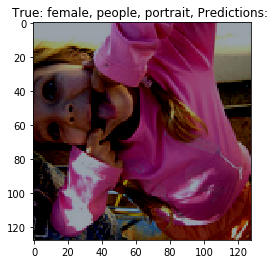

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


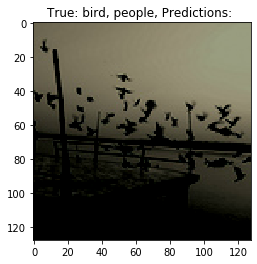

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


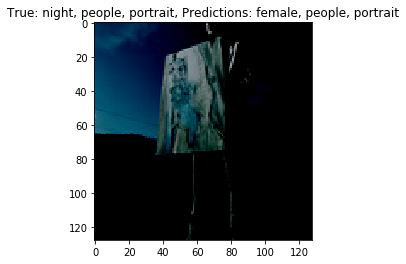

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


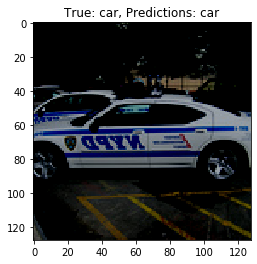

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


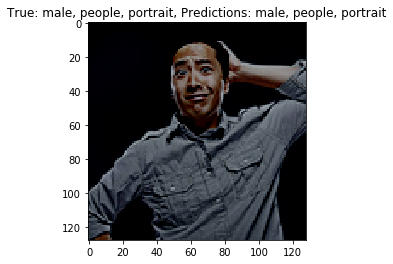

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


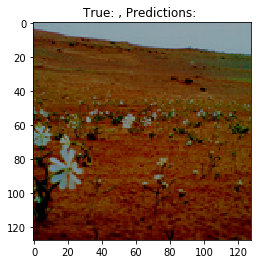

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


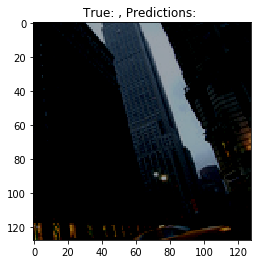

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


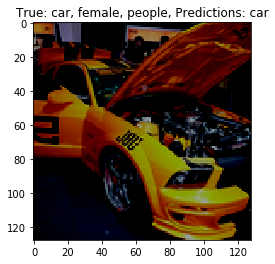

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


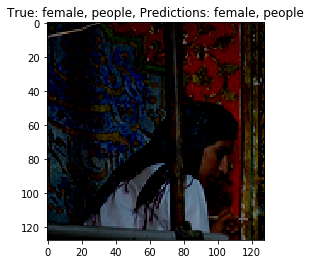

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


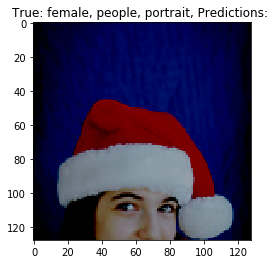

In [122]:
visualize_predictions(model, device, valid_dataloader, n_to_show=10, threshold=0.75)

### Confusion matrix

In [50]:
re_predict = True

if re_predict:

    # Predict
    y_true, y_pred = predict(model, device, valid_dataloader)
    np.save(f'../data/valid_true_labels{affix}.npy', y_true)
    np.save(f'../data/valid_pred_labels{affix}.npy', y_pred)
    
    # Save classification report
    with open(f'../data/valid_classification_report{affix}.txt', 'w') as file:
        file.write(skm.classification_report(y_true, y_pred))
    
    # Save confusion matrix plot
    labels = [k for k, v in get_class_map().items()]
    visualize_confusion_matrix(y_true, y_pred, labels, f'../data/valid_confusion_matrix{affix}.png')

C:\Users\mikko.kotola\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [51]:
# Show classification report
with open(f'../data/valid_classification_report{affix}.txt', 'r') as file:
    report = ''.join(file.readlines())
    print(report)

              precision    recall  f1-score   support

           0       0.21      0.65      0.31        17
           1       0.50      0.82      0.62        77
           2       0.39      0.80      0.52        59
           3       0.43      0.82      0.56       220
           4       0.55      0.80      0.65        92
           5       0.49      0.68      0.57       676
           6       0.38      0.85      0.52       157
           7       0.49      0.62      0.55       608
           8       0.37      0.62      0.47       128
           9       0.59      0.89      0.71      1338
          10       0.78      0.80      0.79       635
          11       0.15      0.45      0.22        20
          12       0.32      0.61      0.42        36
          13       0.49      0.70      0.58       120

   micro avg       0.53      0.77      0.63      4183
   macro avg       0.44      0.72      0.54      4183
weighted avg       0.55      0.77      0.64      4183
 samples avg       0.42   

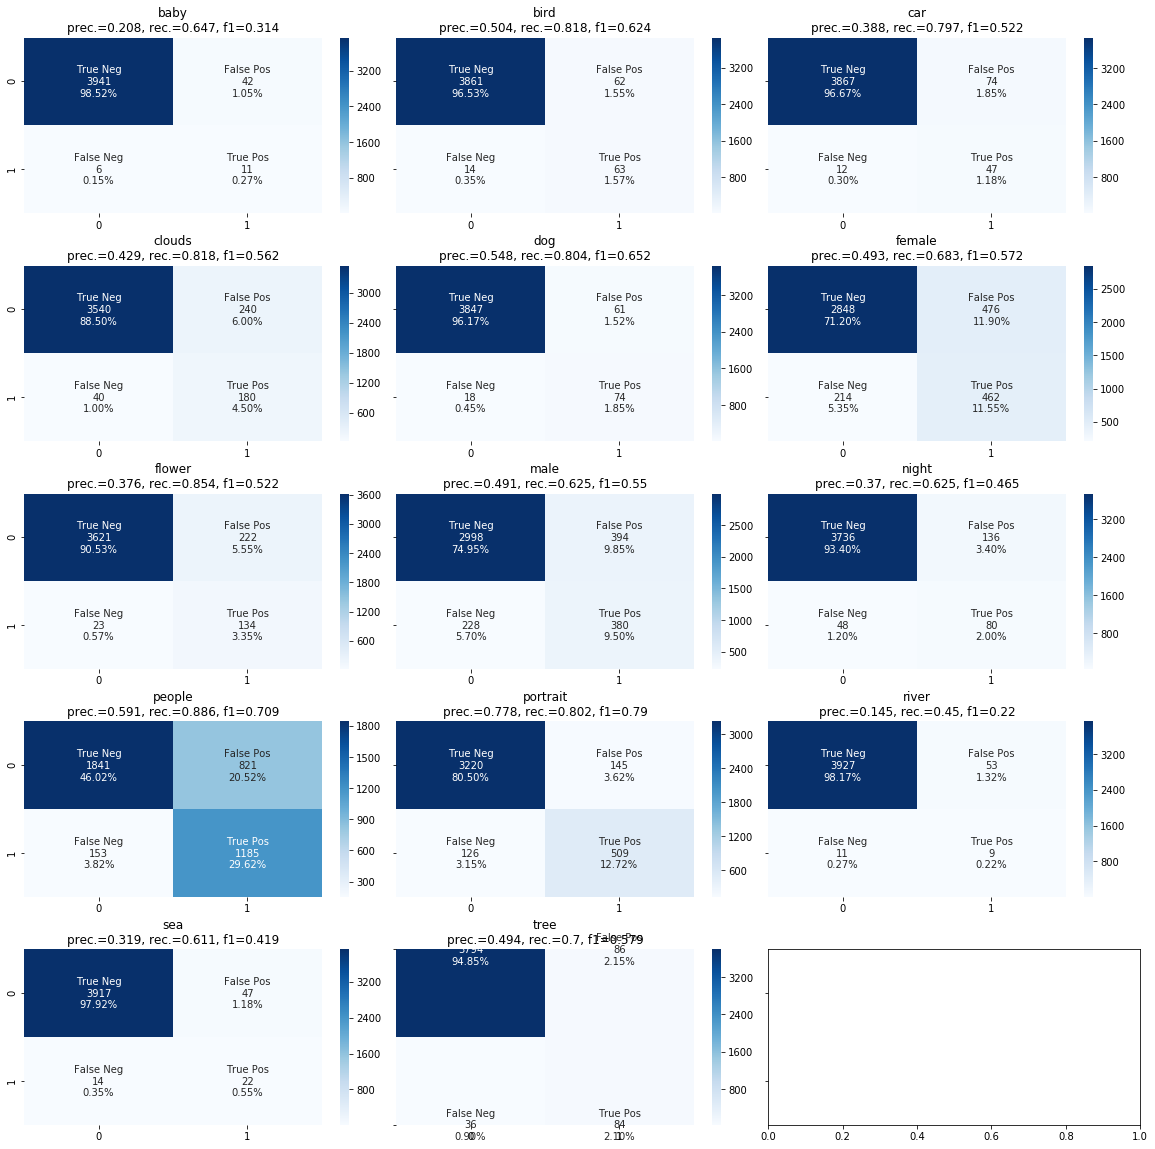

In [52]:
# Show confus|ion matrix plot
IPython_Image(filename=f'../data/valid_confusion_matrix{affix}.png', width=1000)